# Football Diffusion: End-to-End Pipeline

This notebook demonstrates:
1. Data preprocessing
2. Dataset inspection
3. Model evaluation and visualization

**Note**: Model training should be done via command-line:
```bash
python train_main.py --config src/football_diffusion/config/train.yaml
```

If you encounter PyArrow errors during preprocessing, restart the kernel (Kernel → Restart) and re-run all cells from the beginning.


In [1]:
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib

# Add src to path
src_path = str(Path('../src').resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Force reload modules to avoid cached versions
modules_to_reload = [
    'football_diffusion.data.preprocess',
    'football_diffusion.data',
    'football_diffusion.viz',
    'football_diffusion.viz.field',
    'football_diffusion.viz.animate',
    'football_diffusion.viz.evaluate_play'
]
for mod_name in modules_to_reload:
    if mod_name in sys.modules:
        importlib.reload(sys.modules[mod_name])

from football_diffusion.data.preprocess import preprocess_all
from football_diffusion.data.dataset import FootballPlayDataset, collate_fn

# Import visualization functions (try from package first, fallback to direct imports)
try:
    from football_diffusion.viz import (
        plot_trajectory, 
        draw_field, 
        animate_trajectory,
        evaluate_play_quality,
        print_play_quality_report
    )
except ImportError:
    # Fallback: import directly from submodules
    print("Falling back to direct imports...")
    from football_diffusion.viz.field import plot_trajectory, draw_field
    from football_diffusion.viz.animate import animate_trajectory
    from football_diffusion.viz.evaluate_play import evaluate_play_quality, print_play_quality_report

from football_diffusion.utils.seed import set_seed

import yaml

# Set random seed for reproducibility
set_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("Modules loaded - ready for preprocessing and visualization")


PyTorch version: 2.8.0
Device: cpu
Modules loaded - ready for preprocessing and visualization


## 1. Data Preprocessing


In [2]:
# Load config and preprocess data
with open('../src/football_diffusion/config/default.yaml') as f:
    config = yaml.safe_load(f)

raw_dir = Path('../../data/nfl-big-data-bowl-2023')
cache_dir = Path('../../data/cache')
cache_dir.mkdir(parents=True, exist_ok=True)

# Set this to True to force re-preprocessing, False to use cache if available
rerun_preprocessing = False

cache_file = cache_dir / 'processed_plays.pkl'

if rerun_preprocessing:
    print("🔄 Re-running preprocessing (rerun_preprocessing=True)...")
    preprocess_all(raw_dir, cache_dir, config['data'])
    print("✅ Preprocessing complete!")
elif cache_file.exists():
    print(f"✅ Cache file found at {cache_file}")
    print("   Using cached data. Set rerun_preprocessing=True to re-run preprocessing.")
else:
    print("Cache file not found. Running preprocessing...")
    preprocess_all(raw_dir, cache_dir, config['data'])
    print("✅ Preprocessing complete!")


✅ Cache file found at ../../data/cache/processed_plays.pkl
   Using cached data. Set rerun_preprocessing=True to re-run preprocessing.


## 2. Load and Inspect Dataset


In [3]:
# Load datasets - use .pkl file (pickle format)
cache_file = cache_dir / 'processed_plays.pkl'
metadata_file = cache_dir / 'metadata.json'

train_dataset = FootballPlayDataset(cache_file, metadata_file, split='train')
print(f"Train: {len(train_dataset)} plays")

sample = train_dataset[0]
print(f"Sample shape: {sample['X'].shape}")
print(f"Context: {sample['context_categorical']}")


Train: 6485 plays
Sample shape: torch.Size([60, 22, 3])
Context: {'down': 1, 'offensiveFormation': 'SINGLEBACK', 'personnelO': '1 RB, 1 TE, 3 WR', 'defTeam': 'ATL', 'situation': 'long'}


## 3. Model Training

**Training should be done via command-line**, not in this notebook.

Run training from the project root:
```bash
cd diffusion
python train_main.py --config src/football_diffusion/config/train.yaml \
    --cache_dir ../../data/cache \
    --output_dir ../../artifacts/diffusion \
    --gpus 1 \
    --max_epochs 50
```

Or use the provided script:
```bash
bash scripts/train_diffusion.sh
```

This will save model checkpoints to `../../artifacts/diffusion/` which can then be loaded for evaluation below.


## 4. Evaluation and Visualization


Sample play shape: torch.Size([60, 22, 3])
Context: {'down': 1, 'offensiveFormation': 'SINGLEBACK', 'personnelO': '1 RB, 1 TE, 3 WR', 'defTeam': 'ATL', 'situation': 'long'}
✅ Loaded actual player positions from players.csv


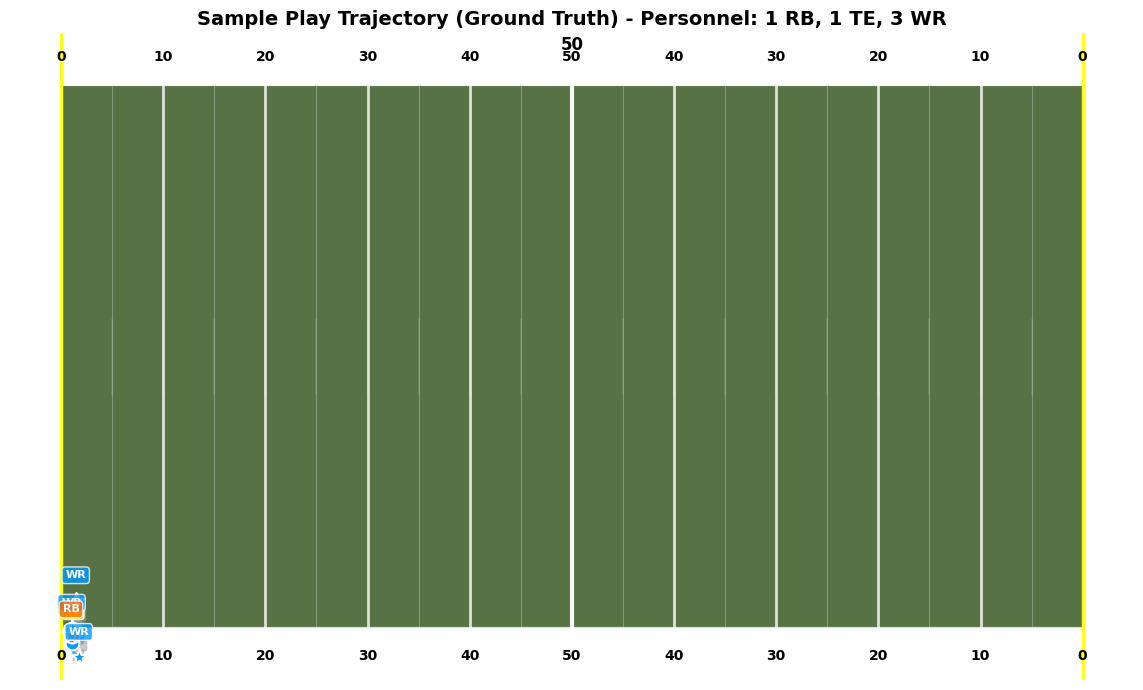


PLAY QUALITY EVALUATION
PLAY QUALITY REPORT
Overall Quality Score: 0.084

Validity Checks:
  ✓ Field Bounds:      31.8% valid
  ✓ Speed Cap:         52.4% valid
  ✓ Overall Validity:  16.7% valid

Realism Metrics:
  ✓ Smoothness:        0.995 (1.0 = perfectly smooth)
  ✓ Movement:          0.51 yards avg displacement
  ✓ Forward Progress:  0.17 yards
  ✓ Direction:         0.504 (1.0 = consistently forward)

Assessment: 🔴 POOR


In [4]:
# Evaluation and visualization examples
# 
# To evaluate a trained model, use the command-line script:
# python -m src.football_diffusion.eval.eval_diffusion \
#     --checkpoint ../../artifacts/diffusion/best.ckpt \
#     --cache_dir ../../data/cache \
#     --config src/football_diffusion/config/eval.yaml \
#     --split test
#
# Or load a model for visualization:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example: Load a trained model (uncomment when you have a checkpoint)
# from football_diffusion.training.train_diffusion import DiffusionLightningModule
# model = DiffusionLightningModule.load_from_checkpoint(
#     '../../artifacts/diffusion/best.ckpt',
#     config=config
# )
# model.model = model.model.to(device)
# model.model.eval()

# Get a sample from the dataset for visualization
sample_play = train_dataset[0]
print(f"Sample play shape: {sample_play['X'].shape}")
print(f"Context: {sample_play['context_categorical']}")

# Visualize the ground truth trajectory with position labels
trajectory = sample_play['X'].numpy()  # [T, P, F]

# Try to load actual player positions from players.csv (most accurate!)
from football_diffusion.viz.load_real_positions import get_real_player_positions
personnel_str = sample_play['context_categorical'].get('personnelO', '')
game_id = sample_play.get('gameId')
play_id = sample_play.get('playId')

# Load actual positions if available
player_labels = None
if game_id and play_id:
    player_labels = get_real_player_positions(raw_dir, game_id, play_id)
    if player_labels:
        print(f"✅ Loaded actual player positions from players.csv")
    else:
        print(f"⚠️  Could not load positions from players.csv, using personnel inference")
else:
    print(f"⚠️  No game_id/play_id available, using personnel inference")

fig, ax = plt.subplots(figsize=(14, 7))
draw_field(ax)
plot_trajectory(
    trajectory, 
    ax=ax, 
    alpha=0.7,
    highlight_skill_only=True,  # Only highlight RB, WR, TE, QB
    show_path=True,
    player_labels=player_labels,  # Use actual positions if loaded
    personnel_str=personnel_str  # Fallback to personnel if positions not available
)
ax.set_title(f'Sample Play Trajectory (Ground Truth) - Personnel: {personnel_str}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Evaluate play quality
print("\n" + "="*60)
print("PLAY QUALITY EVALUATION")
print("="*60)
quality_metrics = evaluate_play_quality(trajectory)
print_play_quality_report(quality_metrics)


In [5]:
## 5. Animated Visualization with Position Labels

# Animate trajectories showing only skill positions (RB, WR, TE, QB) moving, 
# while keeping other players static for clarity.


Visualizing play 0
Context: {'down': 1, 'offensiveFormation': 'SINGLEBACK', 'personnelO': '1 RB, 1 TE, 3 WR', 'defTeam': 'ATL', 'situation': 'long'}
Personnel: 1 RB, 1 TE, 3 WR
Trajectory shape: (60, 22, 3)
✅ Using actual player positions from players.csv
   Positions: ['QB', 'TE', 'WR', 'C', 'WR', 'T', 'G', 'WR', 'RB', 'G', 'T'] (offense)


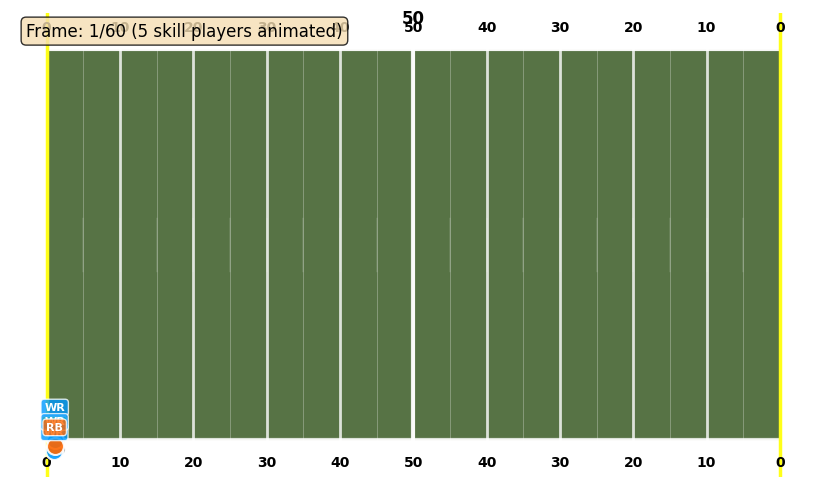

In [5]:
# Enable interactive plotting for animations in Jupyter
%matplotlib inline

# Get a sample trajectory for animation
sample_idx = 0  # Change this to visualize different plays
sample_play = train_dataset[sample_idx]
trajectory = sample_play['X'].numpy()  # [T, P, F]
personnel_str = sample_play['context_categorical'].get('personnelO', '')
game_id = sample_play.get('gameId')
play_id = sample_play.get('playId')

print(f"Visualizing play {sample_idx}")
print(f"Context: {sample_play['context_categorical']}")
print(f"Personnel: {personnel_str}")
print(f"Trajectory shape: {trajectory.shape}")

# Try to load actual player positions from players.csv (most accurate!)
from football_diffusion.viz.load_real_positions import get_real_player_positions
player_labels = None
if game_id and play_id:
    player_labels = get_real_player_positions(raw_dir, game_id, play_id)
    if player_labels:
        print(f"✅ Using actual player positions from players.csv")
        print(f"   Positions: {player_labels[:11]} (offense)")

# Create animated visualization
# This will show only skill positions (RB, WR, TE, QB) moving
# Other players (OL, defense) will be static gray dots
anim, fig = animate_trajectory(
    trajectory,
    interval=100,  # 100ms per frame
    show_field=True,
    animate_skill_only=True,  # Only animate skill positions
    show_trails=True,  # Show trajectory trails
    player_labels=player_labels,  # Use actual positions if loaded
    personnel_str=personnel_str,  # Fallback to personnel if positions not available
    raw_dir=raw_dir,  # Pass raw_dir to enable position loading
    game_id=game_id,
    play_id=play_id
)

# Display animation in Jupyter notebook
from IPython.display import HTML, display
try:
    # Convert to HTML5 video for inline display
    html_anim = HTML(anim.to_jshtml())
    display(html_anim)
except Exception as e:
    # Fallback: show static final frame and provide instructions
    plt.show()
    print(f"\n⚠️  Could not display interactive animation: {e}")
    print("\nTo see the animation, you can:")
    print("  1. Save it as a video (uncomment the line below)")
    print("  2. Use %matplotlib widget instead of inline (requires ipympl)")

# To save the animation as a video (uncomment to save):
# anim.save('sample_play_animation.mp4', writer='ffmpeg', fps=10, bitrate=1800)
# print("Animation saved to sample_play_animation.mp4")


In [ ]:
## 6. Evaluate Multiple Plays

Compare quality metrics across different plays.


In [6]:
# Evaluate multiple plays and compare
num_plays_to_evaluate = 5
print(f"Evaluating {num_plays_to_evaluate} random plays...\n")

all_qualities = []
for i in range(num_plays_to_evaluate):
    sample = train_dataset[i]
    traj = sample['X'].numpy()
    quality = evaluate_play_quality(traj)
    all_qualities.append(quality)
    
    # Context: categorical has 'down', continuous has 'yardsToGo' as first element
    context_cat = sample['context_categorical']
    context_cont = sample['context_continuous'].numpy()
    down = context_cat.get('down', '?')
    yards_to_go = context_cont[0] if len(context_cont) > 0 else '?'
    
    print(f"Play {i+1} - Context: Down {down} & {yards_to_go:.1f} yards to go")
    print(f"  Quality Score: {quality['quality_score']:.3f} | "
          f"Validity: {quality['overall_validity']*100:.1f}% | "
          f"Movement: {quality['movement']:.1f}yd")
    print()

# Summary statistics
avg_quality = np.mean([q['quality_score'] for q in all_qualities])
avg_validity = np.mean([q['overall_validity'] for q in all_qualities])
avg_movement = np.mean([q['movement'] for q in all_qualities])

print("="*60)
print(f"Average across {num_plays_to_evaluate} plays:")
print(f"  Quality Score: {avg_quality:.3f}")
print(f"  Validity: {avg_validity*100:.1f}%")
print(f"  Movement: {avg_movement:.1f} yards")
print("="*60)


Evaluating 5 random plays...

Play 1 - Context: Down 1 & 10.0 yards to go
  Quality Score: 0.084 | Validity: 16.7% | Movement: 0.5yd

Play 2 - Context: Down 1 & 10.0 yards to go
  Quality Score: 0.046 | Validity: 9.2% | Movement: 0.8yd

Play 3 - Context: Down 1 & 10.0 yards to go
  Quality Score: 0.000 | Validity: 0.0% | Movement: 0.6yd

Play 4 - Context: Down 3 & 7.0 yards to go
  Quality Score: 0.108 | Validity: 21.6% | Movement: 0.9yd

Play 5 - Context: Down 1 & 10.0 yards to go
  Quality Score: 0.049 | Validity: 9.9% | Movement: 0.7yd

Average across 5 plays:
  Quality Score: 0.057
  Validity: 11.5%
  Movement: 0.7 yards


## 5. Custom Play Generation

Generate plays with custom conditioning (down, distance, formation, personnel, defense, yardline).


✅ Found best model checkpoint: epoch=50-val_loss=0.000000.ckpt
📦 Loading model from: /Users/sanjjithdinesh/GT/fall 25/deep learning/DL project/nfl_play_suggestion/artifacts/diffusion/epoch=50-val_loss=0.000000.ckpt
   Full path: /Users/sanjjithdinesh/GT/fall 25/deep learning/DL project/nfl_play_suggestion/artifacts/diffusion/epoch=50-val_loss=0.000000.ckpt
✅ Model loaded on device: cpu
   Weight stats: mean=0.004296, std=0.040516

🎯 Generating play with context:
   Down: 2 & 10
   Formation: SHOTGUN
   Personnel: 1 RB, 1 TE, 3 WR
   Defensive Team: ATL
   Yardline: 35 (normalized: 0.35)
   Hash Mark: MIDDLE
   Situation: long

🎨 Generating play... (this may take a moment)
   Sampling with 1000 steps...
   Using formation anchors (t=0 locked to formation)
   Raw output range - X: [-73420.13, 68688.74], Y: [-71589.65, 50803.66]

🔄 Denormalizing coordinates using stored stats...
   Feature means: ['60.1266', '26.5879', '3.0573']
   Feature stds: ['24.7297', '8.7911', '2.0889']
   ✅ Denorm

📝 Saving as GIF (ffmpeg not available). For MP4, install ffmpeg:
   macOS: brew install ffmpeg
   Linux: sudo apt-get install ffmpeg
   Conda: conda install -c conda-forge ffmpeg
✅ Animation saved to play-ATL-2nd_and_10-35.gif
   Full path: /Users/sanjjithdinesh/GT/fall 25/deep learning/DL project/nfl_play_suggestion/diffusion/notebooks/../../reports/videos/play-ATL-2nd_and_10-35.gif

✅ Done! Modify the parameters above to generate different scenarios.


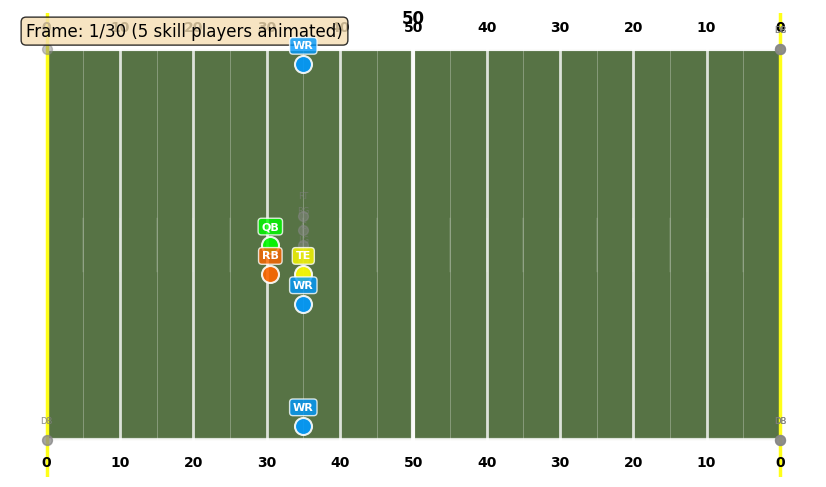

In [20]:
# Custom Play Generation
# Modify these parameters to generate plays for any scenario

from football_diffusion.training.train_diffusion import DiffusionLightningModule
from football_diffusion.data.preprocess import derive_situation
from IPython.display import HTML
import torch
import json
from pathlib import Path

# ============================================================================
# CUSTOM CONTEXT PARAMETERS - MODIFY THESE
# ============================================================================
CUSTOM_DOWN = 2                # Down (1-4)
CUSTOM_YARDS_TO_GO = 10           # Yards needed for first down
CUSTOM_OFFENSIVE_FORMATION = "SHOTGUN"  # Formation (e.g., "SHOTGUN", "UNDER CENTER", "EMPTY")
CUSTOM_PERSONNEL_O = "1 RB, 1 TE, 3 WR"  # Personnel (e.g., "1 RB, 1 TE, 3 WR")
CUSTOM_DEF_TEAM = "ATL"            # Defensive team abbreviation
CUSTOM_YARDLINE = 35             # Yardline (0-100, distance from own goal line)

# Sampling parameters
NUM_SAMPLING_STEPS = 1000            # Number of denoising steps (more = better quality, slower) - 30-35 best
GUIDANCE_SCALE = 2.0               # Classifier-free guidance scale

# ============================================================================
# LOAD MODEL
# ============================================================================
# Load config
config_path = Path('../src/football_diffusion/config/default.yaml')
with open(config_path) as f:
    config = yaml.safe_load(f)

# Ensure cache_dir is defined (from earlier cells)
if 'cache_dir' not in locals():
    cache_dir = Path('../../data/cache')

# Load trained model - specify the best model checkpoint
# Update this path to point to your best trained model
# Using absolute path for clarity
# NEW: Using latest checkpoint from recent training (epoch=53, all 8 weeks, route-focused, with anchors)
BEST_CHECKPOINT = Path('/Users/sanjjithdinesh/GT/fall 25/deep learning/DL project/nfl_play_suggestion/artifacts/diffusion/epoch=50-val_loss=0.000000.ckpt')

# Also try relative path as fallback
if not BEST_CHECKPOINT.exists():
    BEST_CHECKPOINT = Path('../../artifacts/diffusion/epoch=50-val_loss=0.000000-v1.ckpt')

# Fallback logic: try best checkpoint, then last.ckpt, then any checkpoint
checkpoint_path = None

if BEST_CHECKPOINT.exists():
    checkpoint_path = BEST_CHECKPOINT
    print(f"✅ Found best model checkpoint: {BEST_CHECKPOINT.name}")
else:
    # Try last.ckpt
    last_ckpt = Path('../../artifacts/diffusion/last.ckpt')
    if last_ckpt.exists():
        checkpoint_path = last_ckpt
        print(f"⚠️  Best checkpoint not found. Using: {last_ckpt.name}")
    else:
        # Try to find any checkpoint
        checkpoint_dir = Path('../../artifacts/diffusion')
        ckpts = list(checkpoint_dir.glob('*.ckpt'))
        if ckpts:
            # Sort by modification time, use most recent
            ckpts.sort(key=lambda x: x.stat().st_mtime, reverse=True)
            checkpoint_path = ckpts[0]
            print(f"⚠️  Using most recent checkpoint: {checkpoint_path.name}")
        else:
            raise FileNotFoundError(
                f"No checkpoint found. Expected:\n"
                f"  - {BEST_CHECKPOINT}\n"
                f"  - {last_ckpt}\n"
                f"  - Or any .ckpt file in {checkpoint_dir}\n"
                "Please train the model first or update the checkpoint path."
            )

print(f"📦 Loading model from: {checkpoint_path}")
print(f"   Full path: {checkpoint_path.absolute()}")

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    # Load checkpoint manually to check for compatibility issues
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    checkpoint_state = checkpoint.get('state_dict', {})
    
    # Check if we have the old format (2 features vs 3)
    old_weight_key = 'model.context_encoder.continuous_mlp.0.weight'
    needs_migration = False
    
    if old_weight_key in checkpoint_state:
        old_weight_shape = checkpoint_state[old_weight_key].shape
        if old_weight_shape[1] == 2:  # Old format: 2 features
            needs_migration = True
    
    if needs_migration:
        print(f"⚠️  Detected old checkpoint format (2 continuous features)")
        print(f"   Attempting to migrate to new format (3 features)...")
        
        # Extract old continuous_mlp weights before filtering
        old_continuous_weights = checkpoint_state[old_weight_key]  # [hidden_dim, 2]
        old_continuous_bias = checkpoint_state.get('model.context_encoder.continuous_mlp.0.bias', None)
        
        # Filter out the problematic continuous_mlp keys from state dict
        filtered_state = {}
        for key, value in checkpoint_state.items():
            if key != old_weight_key and key != 'model.context_encoder.continuous_mlp.0.bias':
                filtered_state[key] = value
        
        # Create module instance first (will use default initialization)
        module = DiffusionLightningModule(
            config=config,
            num_players=22,
            num_features=3
        )
        
        # Load filtered state dict (will skip continuous_mlp layer)
        missing_keys, unexpected_keys = module.load_state_dict(filtered_state, strict=False)
        
        # Get new layer (expects 3 features)
        new_layer = module.model.context_encoder.continuous_mlp[0]
        new_weight = new_layer.weight.data.clone()  # [hidden_dim, 3]
        new_bias = new_layer.bias.data.clone() if old_continuous_bias is not None else None
        
        # Copy old weights for first 2 features
        new_weight[:, :2] = old_continuous_weights
        # Initialize 3rd feature (hash_mark) weights to small random values
        torch.nn.init.normal_(new_weight[:, 2:], mean=0.0, std=0.01)
        
        if new_bias is not None and old_continuous_bias is not None:
            new_bias.copy_(old_continuous_bias)
        
        # Update the layer with migrated weights
        with torch.no_grad():
            new_layer.weight.data = new_weight
            if new_bias is not None:
                new_layer.bias.data = new_bias
        
        print(f"   ✅ Successfully migrated old checkpoint (2->3 features)")
        print(f"   Hash mark weights initialized to small random values")
    else:
        # New format - load normally
        module = DiffusionLightningModule.load_from_checkpoint(
            str(checkpoint_path),
            config=config,
            strict=True
        )
    
    model = module.model.to(device)
    model.eval()
    print(f"✅ Model loaded on device: {device}")
    
    # Verify checkpoint info
    if hasattr(module, 'hyper_parameters'):
        hparams = module.hyper_parameters
        print(f"   Model config: {hparams.get('num_players', 'N/A')} players, {hparams.get('num_features', 'N/A')} features")
    
    # Check if model was actually trained by verifying some weights
    with torch.no_grad():
        sample_weight = list(model.model.parameters())[0]
        weight_mean = sample_weight.mean().item()
        weight_std = sample_weight.std().item()
        print(f"   Weight stats: mean={weight_mean:.6f}, std={weight_std:.6f}")
        if abs(weight_mean) < 0.0001 and weight_std < 0.01:
            print(f"   ⚠️  WARNING: Weights are very small - model may not be trained!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    import traceback
    traceback.print_exc()
    raise

# ============================================================================
# BUILD CONTEXT
# ============================================================================
# Derive situation from down and yards to go
situation = derive_situation(CUSTOM_DOWN, CUSTOM_YARDS_TO_GO)

# Normalize yardline to [0, 1] (0 = own goal line, 1 = opponent goal line)
yardline_norm = CUSTOM_YARDLINE / 100.0

# Hash mark (can be LEFT, MIDDLE, or RIGHT)
# Default to MIDDLE if not specified
CUSTOM_HASH_MARK = "MIDDLE"  # Change to "LEFT" or "RIGHT" if needed
hash_encoded = 0.5  # MIDDLE = 0.5, LEFT = 0.0, RIGHT = 1.0
if CUSTOM_HASH_MARK.upper() == "LEFT":
    hash_encoded = 0.0
elif CUSTOM_HASH_MARK.upper() == "RIGHT":
    hash_encoded = 1.0

# Build categorical context
context_categorical = [{
    'down': CUSTOM_DOWN,
    'offensiveFormation': CUSTOM_OFFENSIVE_FORMATION,
    'personnelO': CUSTOM_PERSONNEL_O,
    'defTeam': CUSTOM_DEF_TEAM,
    'situation': situation
}]

# Build continuous context [yardsToGo, yardlineNorm, hash_mark]
context_continuous = torch.tensor(
    [[CUSTOM_YARDS_TO_GO, yardline_norm, hash_encoded]],
    dtype=torch.float32
).to(device)

print(f"\n🎯 Generating play with context:")
print(f"   Down: {CUSTOM_DOWN} & {CUSTOM_YARDS_TO_GO}")
print(f"   Formation: {CUSTOM_OFFENSIVE_FORMATION}")
print(f"   Personnel: {CUSTOM_PERSONNEL_O}")
print(f"   Defensive Team: {CUSTOM_DEF_TEAM}")
print(f"   Yardline: {CUSTOM_YARDLINE} (normalized: {yardline_norm:.2f})")
print(f"   Hash Mark: {CUSTOM_HASH_MARK}")
print(f"   Situation: {situation}")

# ============================================================================
# GENERATE PLAY
# ============================================================================
print(f"\n🎨 Generating play... (this may take a moment)")

with torch.no_grad():
    # Get tensor shape from metadata
    metadata_file = cache_dir / 'metadata.json'
    if metadata_file.exists():
        with open(metadata_file) as f:
            metadata = json.load(f)
        T = metadata.get('frames', 60)
        P = metadata.get('players', 22)
        F = len(metadata.get('features', ['x', 'y', 's']))
    else:
        T, P, F = 60, 22, 3
    
    # Compute formation anchors for t=0
    from football_diffusion.data.formation_anchors import get_anchors
    from football_diffusion.data.role_mapping import get_anchor_mask_for_offense, OFFENSE_ROLE_ORDER
    
    anchors_dict = get_anchors(
        formation=CUSTOM_OFFENSIVE_FORMATION,
        personnel=CUSTOM_PERSONNEL_O,
        yardline=CUSTOM_YARDLINE,
        hash_mark=CUSTOM_HASH_MARK,
        direction="right"
    )
    
    # Convert anchors to tensor [P, 2]
    anchors_t0 = np.zeros((P, 2), dtype=np.float32)
    for i, role in enumerate(OFFENSE_ROLE_ORDER):
        if i < P and role in anchors_dict:
            x, y = anchors_dict[role]
            anchors_t0[i, 0] = x
            anchors_t0[i, 1] = y
    
    # Create anchor mask
    anchor_mask = get_anchor_mask_for_offense(P)
    
    # Convert to torch tensors
    anchors_t0_tensor = torch.FloatTensor(anchors_t0).to(device)
    anchor_mask_tensor = torch.BoolTensor(anchor_mask).to(device)
    
    # Get normalization stats if available
    normalization_stats = None
    if hasattr(train_dataset, 'metadata') and 'normalization' in train_dataset.metadata:
        normalization_stats = train_dataset.metadata['normalization']
    
    # Generate play using sample_with_setup (freezes t=0 to anchors)
    print(f"   Sampling with {NUM_SAMPLING_STEPS} steps...")
    print(f"   Using formation anchors (t=0 locked to formation)")
    generated_trajectory = model.sample_with_setup(
        shape=(T, P, F),
        context_categorical=context_categorical,
        context_continuous=context_continuous,
        anchors_t0=anchors_t0_tensor,
        anchor_mask=anchor_mask_tensor,
        num_steps=NUM_SAMPLING_STEPS,
        freeze_t0=True,
        normalization_stats=normalization_stats
    )
    
    # Check intermediate coordinate ranges after generation (before any clipping)
    x_raw = generated_trajectory[0, :, :, 0].cpu().numpy()
    y_raw = generated_trajectory[0, :, :, 1].cpu().numpy()
    print(f"   Raw output range - X: [{x_raw.min():.2f}, {x_raw.max():.2f}], Y: [{y_raw.min():.2f}, {y_raw.max():.2f}]")
    
    # Convert to numpy (model outputs normalized coordinates)
    generated_trajectory = generated_trajectory[0].cpu().numpy()  # [T, P, F] - normalized
    
    # DENORMALIZE coordinates back to field space
    from football_diffusion.data.normalize import denormalize_tensor
    
    if 'normalization' in train_dataset.metadata:
        normalization_stats = train_dataset.metadata['normalization']
        print(f"\n🔄 Denormalizing coordinates using stored stats...")
        print(f"   Feature means: {[f'{m:.4f}' for m in normalization_stats['means']]}")
        print(f"   Feature stds: {[f'{s:.4f}' for s in normalization_stats['stds']]}")
        generated_trajectory = denormalize_tensor(generated_trajectory, normalization_stats)
        print(f"   ✅ Denormalized to field coordinates")
    else:
        print(f"\n⚠️  No normalization stats found - coordinates are already in field space")
    
    # Compare with a real play from the dataset (also denormalize if needed)
    print(f"\n🔍 Comparing with real play from dataset:")
    real_sample = train_dataset[0]
    real_traj = real_sample['X'].numpy()
    
    # Denormalize real play too if normalization was applied
    if 'normalization' in train_dataset.metadata:
        real_traj = denormalize_tensor(real_traj, train_dataset.metadata['normalization'])
    
    real_x = real_traj[:, :, 0]
    real_y = real_traj[:, :, 1]
    print(f"   Real play - X: [{real_x.min():.2f}, {real_x.max():.2f}], Y: [{real_y.min():.2f}, {real_y.max():.2f}]")
    
    # Check coordinate ranges (now in field space)
    x_coords = generated_trajectory[:, :, 0].copy()
    y_coords = generated_trajectory[:, :, 1].copy()
    print(f"\n📊 Generated coordinate ranges (denormalized, field space):")
    print(f"   X: [{x_coords.min():.2f}, {x_coords.max():.2f}] (expected: ~0-100)")
    print(f"   Y: [{y_coords.min():.2f}, {y_coords.max():.2f}] (expected: ~0-53.3)")
    print(f"   X mean: {x_coords.mean():.2f}, std: {x_coords.std():.2f}")
    print(f"   Y mean: {y_coords.mean():.2f}, std: {y_coords.std():.2f}")
    
    # Check if coordinates are reasonable
    x_mean_expected = 50  # Middle of field
    y_mean_expected = 27  # Middle of field width
    x_range_expected = (0, 100)
    y_range_expected = (0, 53.3)
    
    if (x_range_expected[0] - 10 <= x_coords.mean() <= x_range_expected[1] + 10 and
        y_range_expected[0] - 10 <= y_coords.mean() <= y_range_expected[1] + 10):
        print(f"\n✅ Coordinates look reasonable! Mean is within expected field bounds.")
    else:
        print(f"\n⚠️  WARNING: Coordinates seem unusual!")
        print(f"   Real plays have mean X: {real_x.mean():.2f}, mean Y: {real_y.mean():.2f}")
        print(f"   Generated plays have mean X: {x_coords.mean():.2f}, mean Y: {y_coords.mean():.2f}")
    
    # Clip coordinates to valid field bounds
    generated_trajectory[:, :, 0] = np.clip(generated_trajectory[:, :, 0], 0, 100)
    generated_trajectory[:, :, 1] = np.clip(generated_trajectory[:, :, 1], 0, 53.3)
    
    print(f"\n✅ Coordinates clipped to field bounds [0-100, 0-53.3]")
    
    # ============================================================================
    # POST-PROCESSING: SMOOTH TRAJECTORY FOR GRADUAL MOVEMENT
    # ============================================================================
    # Apply smoothing to make movement gradual (~1 yard per frame) and prevent erratic movement
    # This works immediately without retraining!
    print(f"\n🔄 Applying trajectory smoothing for gradual movement...")
    from football_diffusion.utils.trajectory_smoothing import apply_comprehensive_smoothing
    
    # Smooth the trajectory (constrains velocity to ~1 yard/frame, prevents reversals)
    generated_trajectory_smoothed = apply_comprehensive_smoothing(
        generated_trajectory,
        max_velocity=1.0,  # Max 1 yard per frame for gradual movement
        preserve_t0=True  # Keep t=0 formation anchors unchanged
    )
    
    # Verify smoothing effect
    if len(generated_trajectory_smoothed) > 1:
        # Check velocity from t=0 to t=1
        vel_t0_t1 = np.linalg.norm(
            generated_trajectory_smoothed[1, :, :2] - generated_trajectory_smoothed[0, :, :2],
            axis=1
        )
        avg_vel = vel_t0_t1.mean()
        max_vel = vel_t0_t1.max()
        print(f"   ✅ Smoothed trajectory:")
        print(f"      Average velocity (t=0→1): {avg_vel:.2f} yards/frame")
        print(f"      Max velocity (t=0→1): {max_vel:.2f} yards/frame")
        print(f"      (Target: ~1.0 yards/frame for gradual movement)")
    
    # Use smoothed trajectory
    generated_trajectory = generated_trajectory_smoothed

print(f"✅ Play generated! Shape: {generated_trajectory.shape}")

# ============================================================================
# VISUALIZE GENERATED PLAY
# ============================================================================
print(f"\n🎬 Animating generated play...")

# Generate position labels based on FIXED player ordering from preprocessing
# The fixed order is: QB, RB, WR1, WR2, WR3, TE1, LT, LG, C, RG, RT (offense)
# Then: CB1, CB2, S1, S2, LB1, LB2, LB3, DE1, DT, DE2, NB (defense)
from football_diffusion.data.role_mapping import OFFENSE_ROLE_ORDER, DEFENSE_ROLE_ORDER

# Build labels to match the fixed ordering
player_labels = []

# Offense (first 11): Use OFFENSE_ROLE_ORDER
# QB is always index 0
player_labels.append('QB')

# Parse personnel to understand what we have
from football_diffusion.viz.position_utils import parse_personnel
counts = parse_personnel(CUSTOM_PERSONNEL_O)
num_rb = counts.get('RB', 0)
num_wr = counts.get('WR', 0)
num_te = counts.get('TE', 0)

# Fill in skill positions in order: RB, then WRs, then TE
# Index 1: RB (if exists)
if num_rb > 0:
    player_labels.append('RB')
else:
    player_labels.append('UNKNOWN')

# Indices 2-4: WRs (up to 3)
for i in range(min(num_wr, 3)):
    player_labels.append('WR')

# Pad WRs if less than 3
while len(player_labels) < 3 + (1 if num_rb > 0 else 0):  # QB + (RB?) + WRs
    if len(player_labels) < 5:  # Before TE slot
        player_labels.append('WR' if num_wr > 0 else 'UNKNOWN')

# Index 5: TE
if num_te > 0:
    player_labels.append('TE')
else:
    player_labels.append('UNKNOWN')

# Indices 6-10: OL (LT, LG, C, RG, RT)
ol_labels = ['LT', 'LG', 'C', 'RG', 'RT']
player_labels.extend(ol_labels[:5])

# Ensure we have exactly 11 offense players
player_labels = player_labels[:11]
while len(player_labels) < 11:
    player_labels.append('OL')

# Defense (next 11): Use DEFENSE_ROLE_ORDER labels (simplified to DB for visualization)
player_labels.extend(['DB'] * 11)  # Defense players

# Animate the generated play
%matplotlib inline
from IPython.display import HTML
import matplotlib

# Reduce animation size by:
# 1. Increase embed limit (optional - allows larger animations)
matplotlib.rcParams['animation.embed_limit'] = 50.0  # 50 MB limit

# 2. Subsample frames to reduce animation size (show every Nth frame)
SUBSAMPLE_FRAMES = 2  # Show every 2nd frame (30 frames instead of 60)
if SUBSAMPLE_FRAMES > 1:
    subsampled_trajectory = generated_trajectory[::SUBSAMPLE_FRAMES]
    print(f"📊 Using subsampled trajectory: {len(subsampled_trajectory)} frames (every {SUBSAMPLE_FRAMES} frames)")
else:
    subsampled_trajectory = generated_trajectory

# 3. Create animation with optimized settings
anim, fig = animate_trajectory(
    subsampled_trajectory,  # Use subsampled trajectory
    player_labels=player_labels,
    personnel_str=CUSTOM_PERSONNEL_O,
    animate_skill_only=True,  # Only animate skill positions
    show_trails=True,
    interval=150  # Increased from 100ms to 150ms (slower = less data per frame)
)

# Reduce figure size to reduce animation size
fig.set_size_inches(10, 5)  # Reduced from (14, 7)

# Display animation
from IPython.display import display
try:
    display(HTML(anim.to_jshtml()))
except Exception as e:
    print(f"⚠️  Could not embed animation (too large): {e}")
    print("\n💡 Alternatives:")
    print("  1. Increase SUBSAMPLE_FRAMES (e.g., set to 3 or 4)")
    print("  2. Save animation to file instead (uncomment below)")
    print("  3. Show static plot instead")
    
    # Fallback: show static final frame
    plt.show()

# Alternative: Save animation to file instead of embedding
# Uncomment the following lines to save animation instead:
import subprocess
import os
from pathlib import Path
from datetime import datetime

# Create reports/videos directory if it doesn't exist
reports_dir = Path('../../reports/videos')  # Relative to notebooks directory
reports_dir.mkdir(parents=True, exist_ok=True)

# Generate unique filename based on play context
# Format: play-{DEF_TEAM}-{DOWN}st_and_{YARDS}-{YARDLINE}.gif
# Example: play-DAL-1st_and_10-50.gif

# Map down number to text
down_map = {1: '1st', 2: '2nd', 3: '3rd', 4: '4th'}
down_text = down_map.get(CUSTOM_DOWN, f'{CUSTOM_DOWN}th')

# Create base filename
base_filename = f"play-{CUSTOM_DEF_TEAM}-{down_text}_and_{int(CUSTOM_YARDS_TO_GO)}-{int(CUSTOM_YARDLINE)}"

# Check if file exists and add counter if needed
counter = 0
while True:
    if counter == 0:
        filename = f"{base_filename}.gif"
    else:
        filename = f"{base_filename}_{counter}.gif"
    
    save_path = reports_dir / filename
    if not save_path.exists():
        break
    counter += 1

# Check if ffmpeg is available
ffmpeg_available = False
try:
    subprocess.run(['ffmpeg', '-version'], capture_output=True, check=True)
    ffmpeg_available = True
except (subprocess.CalledProcessError, FileNotFoundError):
    ffmpeg_available = False

if ffmpeg_available:
    # Save as MP4 using ffmpeg
    mp4_filename = filename.replace('.gif', '.mp4')
    save_path_mp4 = reports_dir / mp4_filename
    try:
        anim.save(str(save_path_mp4), writer='ffmpeg', fps=6.67, bitrate=1000)
        print(f"✅ Animation saved to {save_path_mp4.name}")
        print(f"   Full path: {save_path_mp4.absolute()}")
    except Exception as e:
        print(f"⚠️  Could not save as MP4: {e}")
        print("   Falling back to GIF format...")
        # Fallback to GIF
        try:
            anim.save(str(save_path), writer='pillow', fps=6.67)
            print(f"✅ Animation saved to {save_path.name} (GIF format)")
            print(f"   Full path: {save_path.absolute()}")
        except Exception as e2:
            print(f"❌ Could not save animation: {e2}")
else:
    # ffmpeg not available, save as GIF
    print(f"📝 Saving as GIF (ffmpeg not available). For MP4, install ffmpeg:")
    print(f"   macOS: brew install ffmpeg")
    print(f"   Linux: sudo apt-get install ffmpeg")
    print(f"   Conda: conda install -c conda-forge ffmpeg")
    try:
        anim.save(str(save_path), writer='pillow', fps=6.67)
        print(f"✅ Animation saved to {save_path.name}")
        print(f"   Full path: {save_path.absolute()}")
    except Exception as e:
        print(f"❌ Could not save animation: {e}")

print(f"\n✅ Done! Modify the parameters above to generate different scenarios.")


In [22]:
## 6. Evaluate Generated Play Metrics

#Compute comprehensive evaluation metrics for the generated play (same format as autoregressive model evaluation).

# Import evaluation functions
import sys
sys.path.insert(0, str(Path('../../').resolve()))

from src.eval import (
    evaluate_trajectory_model,
    print_trajectory_report
)

# Find a matching ground truth play from the dataset for comparison
print("=" * 70)
print("🔍 Finding matching ground truth play for comparison...")
print("=" * 70)

# Search for plays with similar context
matching_plays = []
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    cat_ctx = sample['context_categorical']
    cont_ctx = sample['context_continuous'].numpy()
    
    # Check if context matches (allow some tolerance)
    down_match = cat_ctx.get('down') == CUSTOM_DOWN
    yards_match = abs(cont_ctx[0] - CUSTOM_YARDS_TO_GO) < 2  # Within 2 yards
    formation_match = cat_ctx.get('offensiveFormation', '').upper() == CUSTOM_OFFENSIVE_FORMATION.upper()
    def_team_match = cat_ctx.get('defTeam', '') == CUSTOM_DEF_TEAM
    
    # Score match quality
    match_score = 0
    if down_match:
        match_score += 4
    if yards_match:
        match_score += 3
    if formation_match:
        match_score += 2
    if def_team_match:
        match_score += 1
    
    if match_score >= 4:  # At least down and yards match
        matching_plays.append((i, match_score, sample))

# Sort by match score and take best match
if matching_plays:
    matching_plays.sort(key=lambda x: x[1], reverse=True)
    best_match_idx, match_score, best_match_sample = matching_plays[0]
    
    print(f"✅ Found matching play (index {best_match_idx}, score: {match_score}/10)")
    print(f"   Context: Down {best_match_sample['context_categorical'].get('down')} & "
          f"{best_match_sample['context_continuous'].numpy()[0]:.1f} yards, "
          f"Formation: {best_match_sample['context_categorical'].get('offensiveFormation')}, "
          f"Def: {best_match_sample['context_categorical'].get('defTeam')}")
    
    # Get ground truth trajectory
    ground_truth_traj = best_match_sample['X'].numpy()  # [T, P, F]
    
    # Denormalize ground truth if needed
    if 'normalization' in train_dataset.metadata:
        from football_diffusion.data.normalize import denormalize_tensor
        ground_truth_traj = denormalize_tensor(
            ground_truth_traj, 
            train_dataset.metadata['normalization']
        )
    
    # Prepare trajectories for evaluation
    # Evaluate functions can handle both [batch, T, P*F] and [batch, T, P, F] formats
    # We'll use [batch, T, P*F] format to match expected input
    T, P, F = generated_trajectory.shape
    
    # Reshape to [batch, T, P*F] format
    # Flatten player and feature dimensions: [T, P, F] -> [T, P*F]
    pred_reshaped = generated_trajectory.reshape(T, P * F)  # [T, P*F]
    pred_reshaped = pred_reshaped[np.newaxis, :, :]  # [1, T, P*F]
    
    gt_reshaped = ground_truth_traj.reshape(T, P * F)  # [T, P*F]
    gt_reshaped = gt_reshaped[np.newaxis, :, :]  # [1, T, P*F]
    
    print(f"\n📊 Computing comprehensive metrics...")
    print(f"   Generated shape: {generated_trajectory.shape} -> {pred_reshaped.shape} (reshaped)")
    print(f"   Ground truth shape: {ground_truth_traj.shape} -> {gt_reshaped.shape} (reshaped)")
    
    # Compute all metrics using the evaluation functions
    fps = 10.0  # 10 Hz tracking data
    
    # Compute metrics using the comprehensive evaluation function
    metrics = evaluate_trajectory_model(
        pred=pred_reshaped,  # [1, T, P*F] format
        target=gt_reshaped,  # [1, T, P*F] format
        mask=None,
        num_players=P,
        features_per_player=F,  # x, y, s = 3 features
        collision_threshold=1.0,  # 1 yard collision threshold
        fps=fps
    )
    
    # Print comprehensive report
    print_trajectory_report(metrics, "Diffusion Model (Generated vs Ground Truth)")
    
    print("\n" + "=" * 70)
    print("✅ Evaluation complete!")
    print("=" * 70)
    
else:
    print("⚠️  No matching ground truth play found with similar context.")
    print("   Computing standalone metrics (without ground truth comparison)...")
    
    # Compute standalone metrics (no ground truth needed)
    T, P, F = generated_trajectory.shape
    
    # Physical validity metrics (no ground truth needed)
    from src.eval import compute_physical_validity, compute_collision_rate
    
    traj_for_eval = generated_trajectory.reshape(1, T, P * F)
    
    phys_metrics = compute_physical_validity(
        traj_for_eval,
        fps=10.0,
        num_players=P,
        features_per_player=F
    )
    
    collision_rate = compute_collision_rate(
        traj_for_eval,
        threshold=1.0,
        num_players=P,
        features_per_player=F
    )
    
    print("\n🏃 Physical Validity (Standalone):")
    print(f"  Speed violation rate: {phys_metrics.get('speed_violation_rate', 0)*100:.2f}%")
    print(f"  Acceleration violation rate: {phys_metrics.get('accel_violation_rate', 0)*100:.2f}%")
    print(f"  Out of bounds rate: {phys_metrics.get('out_of_bounds_rate', 0)*100:.2f}%")
    print(f"  Mean speed: {phys_metrics.get('mean_speed', 0):.2f} yards/s")
    print(f"  Max speed: {phys_metrics.get('max_speed', 0):.2f} yards/s")
    
    print("\n💥 Collision Rate:")
    print(f"  Player collision rate: {collision_rate*100:.2f}%")
    
    print("\n⚠️  Note: ADE, FDE, and accuracy metrics require ground truth comparison.")
    print("   Try adjusting CUSTOM parameters to match a play in the dataset.")



🔍 Finding matching ground truth play for comparison...
✅ Found matching play (index 1504, score: 10/10)
   Context: Down 2 & 10.0 yards, Formation: SHOTGUN, Def: ATL

📊 Computing comprehensive metrics...
   Generated shape: (60, 22, 3) -> (1, 60, 66) (reshaped)
   Ground truth shape: (60, 22, 3) -> (1, 60, 66) (reshaped)

Trajectory Evaluation Report: Diffusion Model (Generated vs Ground Truth)

📏 Displacement Errors:
  ADE: 35.828 yards
  FDE: 38.452 yards

🎯 Accuracy Metrics:
  Within 1 yard:  0.00%
  Within 2 yards: 0.00%
  Within 5 yards: 1.44%
  Direction accuracy: 48.96%
  Frame accuracy (all players within 2yd): 0.00%

🏃 Physical Validity:
  Speed violation rate: 0.00%
  Acceleration violation rate: 7.05%
  Out of bounds rate: 11.29%
  Mean speed: 5.20 yards/s
  Max speed: 10.00 yards/s

🏈 Formation Coherence:
  Mean spread change: 2.119 yards
  Final centroid displacement: 4.302 yards

💥 Collision Rate:
  Player collision rate: 28.33%


✅ Evaluation complete!
